In [2]:
import os
import inspect
import csv as csv
import re
import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from xgboost import plot_tree
import matplotlib.pyplot as plt
import textwrap

from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.tree import _tree, DecisionTreeRegressor, plot_tree
from sklearn.feature_selection import mutual_info_regression, RFE, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
    classification_report
)
from lightgbm import LGBMRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb

from category_encoders import TargetEncoder

In [3]:
df = pd.read_csv('pca2.csv')
df.head()

,SERIALNO,SPORDER,WAGP,AGEP,COW,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,HISP,INDP,OCCP,SCIENGP,SCIENGRLP,RACE
0,2023000000009,1,3600,19,1,19,2,16,1,7220,8,2,8680,4055,3,3,0
1,2023000000028,1,800,23,1,19,1,15,1,7115,1,1,8564,2850,3,3,1
2,2023000000052,1,1800,23,1,20,1,15,1,7115,1,1,8564,2850,3,3,1
3,2023000000125,1,65000,28,1,19,1,40,6,4492,9,2,4796,4760,3,3,0
4,2023000000152,1,3000,20,1,19,2,20,6,61101,2,1,7870,4640,3,3,2


In [4]:
df.dtypes

SERIALNO     int64
SPORDER      int64
WAGP         int64
AGEP         int64
COW          int64
SCHL         int64
SEX          int64
WKHP         int64
ESR          int64
NAICSP       int64
RAC1P        int64
HISP         int64
INDP         int64
OCCP         int64
SCIENGP      int64
SCIENGRLP    int64
RACE         int64
dtype: object

# Correlation Matrix

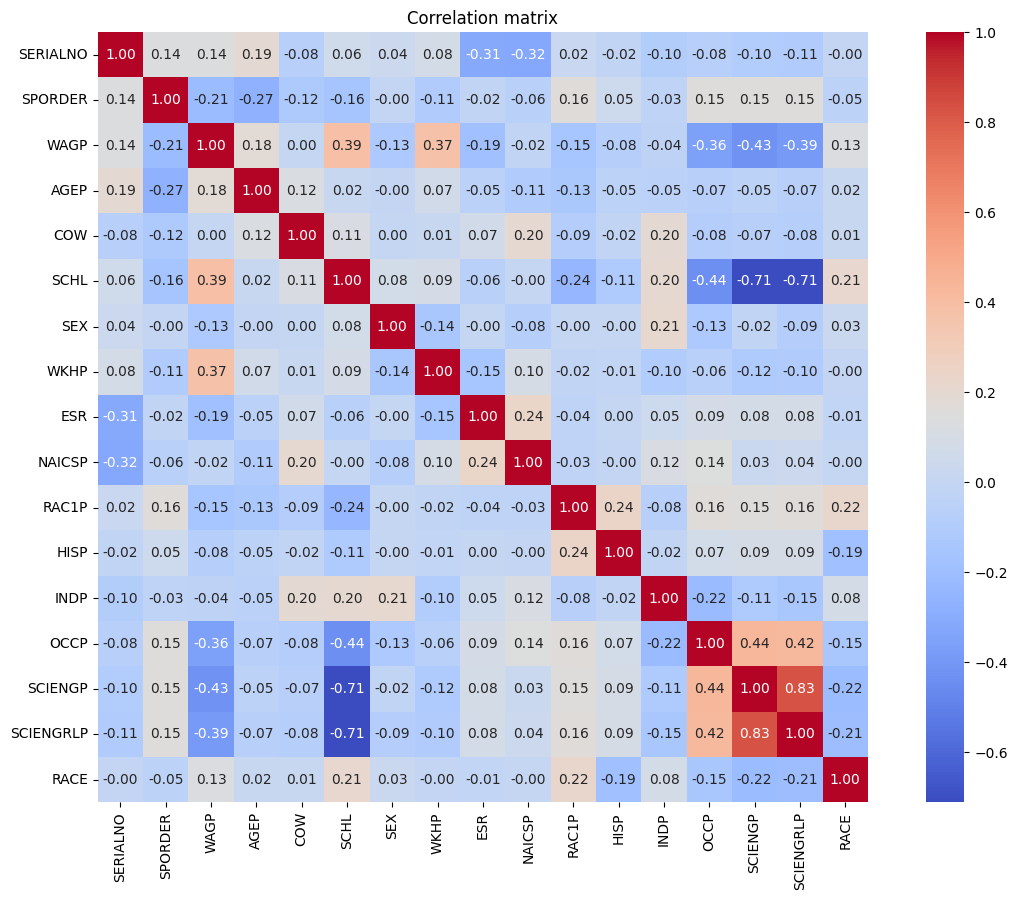

In [5]:
corr_matrix = df.corr()
plt.figure(figsize = (15,10))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt='.2f', square = True)
plt.title("Correlation matrix")
plt.show()

In [6]:
# Assuming 'data' is your DataFrame and 'WAGP' is one of the columns
wagp_corr = df.corr()['WAGP'].drop('WAGP')  # Drop self-correlation

# Sort by absolute correlation (descending)
sorted_wagp_corr = wagp_corr.reindex(wagp_corr.abs().sort_values(ascending=False).index)

# Display
print(sorted_wagp_corr)


SCIENGP     -0.425405
SCHL         0.391212
SCIENGRLP   -0.389046
WKHP         0.373231
OCCP        -0.360695
SPORDER     -0.212767
ESR         -0.185261
AGEP         0.178154
RAC1P       -0.150654
SERIALNO     0.135841
RACE         0.128825
SEX         -0.125287
HISP        -0.082008
INDP        -0.037894
NAICSP      -0.018398
COW          0.002861
Name: WAGP, dtype: float64


# Explore Simple DS Modeling

In [7]:
dfSimple = df[['WAGP', 'SCIENGP', 'SCHL', 'WKHP', 'OCCP', 'ESR', 'AGEP']]
dfSimple['WAGP_log']= np.log(df['WAGP'])
dfSimple.head()

C:\Users\rohan\AppData\Local\Temp\ipykernel_14488\1901531213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSimple['WAGP_log']= np.log(df['WAGP'])


,WAGP,SCIENGP,SCHL,WKHP,OCCP,ESR,AGEP,WAGP_log
0,3600,3,19,16,4055,1,19,8.188689
1,800,3,19,15,2850,1,23,6.684612
2,1800,3,20,15,2850,1,23,7.495542
3,65000,3,19,40,4760,6,28,11.082143
4,3000,3,19,20,4640,6,20,8.006368


In [8]:
# with WAGP LOG

# Copy dataset
#dfStack = df_clean.copy()
dfStack = dfSimple.copy()

# Define target variable
y = dfStack['WAGP_log'] 
# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'WAGP_log'])

#scaler = StandardScaler()
#X[num_features] = scaler.fit_transform(X[num_features])
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
#=======================
# Define models
xgb_model = XGBRegressor(
    n_estimators=300, 
    learning_rate=0.05,
    max_depth=12, 
    min_child_weight=2,
    colsample_bytree=0.75,
    subsample=0.9,
    #reg_alpha=0.1,
    #reg_lambda=0.1,
    random_state=5555
)
# Train both models
%time xgb_model.fit(X_train, y_train)
# Get predictions
%time y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB Model R-squared Score: {r2_xgb:.4f}")

CPU times: total: 30.5 s
Wall time: 8.87 s
CPU times: total: 2.2 s
Wall time: 606 ms
XGB Model R-squared Score: 0.5996


# Advanced XGB Model

## Feature Engineering

In [9]:
# Ensure SCHL is an integer type before mapping
df['SCHL'] = df['SCHL'].astype(int)

# Define the education level mapping
edu_mapping = {
    15: 'High school',
    19: 'High school graduate',
    20: 'Associates',
    21: 'Bachelors',
    22: 'Masters',
    23: 'Professional degree beyond bachelors',
    24: 'Doctorate'
}

# Apply the mapping
df['SCHL'] = df['SCHL'].map(edu_mapping)

# Convert to categorical encoding
df['SCHL_Encoded'] = df['SCHL'].astype('category').cat.codes

# Display transformed dataset
df.head()

,SERIALNO,SPORDER,WAGP,AGEP,COW,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,HISP,INDP,OCCP,SCIENGP,SCIENGRLP,RACE,SCHL_Encoded
0,2023000000009,1,3600,19,1,High school graduate,2,16,1,7220,8,2,8680,4055,3,3,0,4
1,2023000000028,1,800,23,1,High school graduate,1,15,1,7115,1,1,8564,2850,3,3,1,4
2,2023000000052,1,1800,23,1,Associates,1,15,1,7115,1,1,8564,2850,3,3,1,0
3,2023000000125,1,65000,28,1,High school graduate,1,40,6,4492,9,2,4796,4760,3,3,0,4
4,2023000000152,1,3000,20,1,High school graduate,2,20,6,61101,2,1,7870,4640,3,3,2,4


In [10]:
# 1. Convert COW (Class of Worker) to categorical encoding
df['COW'] = df['COW'].astype('category')

# 2. Create a log of Wage 
df['WAGP_Log'] = np.log(df['WAGP'])

# 3. Bin WKHP (Worked Hours Per Week)
df['WKHP_Binned'] = pd.cut(df['WKHP'], bins=[0, 30, 45, np.inf], labels=['Part-Time', 'Full-Time', 'Overtime'])

# 4. Convert INDP (Industry Code) to categorical encoding
df['INDP'] = df['INDP'].astype('category')

# Display transformed dataset
print(df.head())

        SERIALNO  SPORDER   WAGP  AGEP COW                  SCHL  SEX  WKHP  \
0  2023000000009        1   3600    19   1  High school graduate    2    16   
1  2023000000028        1    800    23   1  High school graduate    1    15   
2  2023000000052        1   1800    23   1            Associates    1    15   
3  2023000000125        1  65000    28   1  High school graduate    1    40   
4  2023000000152        1   3000    20   1  High school graduate    2    20   

   ESR  NAICSP  RAC1P  HISP  INDP  OCCP  SCIENGP  SCIENGRLP  RACE  \
0    1    7220      8     2  8680  4055        3          3     0   
1    1    7115      1     1  8564  2850        3          3     1   
2    1    7115      1     1  8564  2850        3          3     1   
3    6    4492      9     2  4796  4760        3          3     0   
4    6   61101      2     1  7870  4640        3          3     2   

   SCHL_Encoded   WAGP_Log WKHP_Binned  
0             4   8.188689   Part-Time  
1             4   6.684612  

In [11]:

def remove_top_5_percent(df, target_feature):
    """
    Removes the top 5% of values from the specified target feature in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target_feature (str): The column name of the target feature.

    Returns:
    pd.DataFrame: A new DataFrame with the top 5% of values removed.
    """
    threshold = df[target_feature].quantile(0.95)  # Calculate 95th percentile
    return df[df[target_feature] <= threshold]  # Keep only values below the threshold

df_clean = remove_top_5_percent(df, 'WAGP')
print(len(df_clean))

177800


In [12]:
df_clean = pd.get_dummies(df_clean, columns=['COW', 'WKHP_Binned'], drop_first=True)
print(df_clean.columns)


Index(['SERIALNO', 'SPORDER', 'WAGP', 'AGEP', 'SCHL', 'SEX', 'WKHP', 'ESR',
       'NAICSP', 'RAC1P', 'HISP', 'INDP', 'OCCP', 'SCIENGP', 'SCIENGRLP',
       'RACE', 'SCHL_Encoded', 'WAGP_Log', 'COW_2', 'COW_3', 'COW_4', 'COW_5',
       'COW_6', 'COW_7', 'COW_8', 'WKHP_Binned_Full-Time',
       'WKHP_Binned_Overtime'],
      dtype='object')


In [13]:
encoder = TargetEncoder(cols=['INDP'])
df_clean['INDP_Encoded'] = encoder.fit_transform(df_clean['INDP'], df_clean['WAGP'])  


# Imbalance Analysis

In [15]:
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        wrapped_text = textwrap.fill(text, width=width, break_long_words=break_long_words)
        labels.append(wrapped_text)
    ax.set_xticklabels(labels, rotation=0)

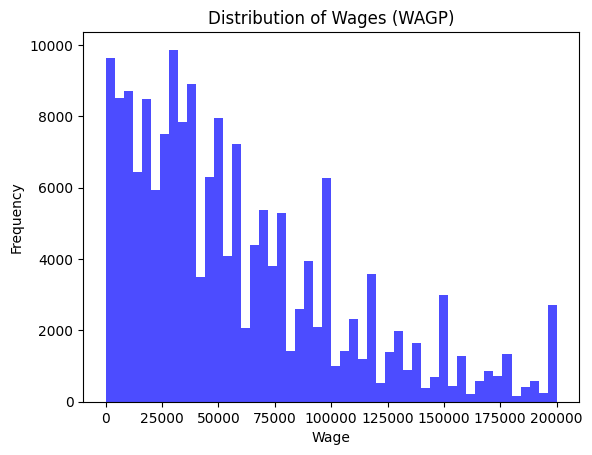

count    177800.000000
mean      58706.439989
std       47379.602731
min           4.000000
25%       22800.000000
50%       46000.000000
75%       85000.000000
max      200000.000000
Name: WAGP, dtype: float64
20000     38720
0         37643
40000     28956
60000     22453
80000     15232
100000    11624
120000     8190
140000     6030
160000     3649
180000     2719
200000     2584
Name: WAGE_CLASS, dtype: int64
RACE counts
0    66482
1    61498
6    32372
9     7846
2     7214
8     1142
3      592
7      508
5      133
4       13
Name: RACE, dtype: int64
=====


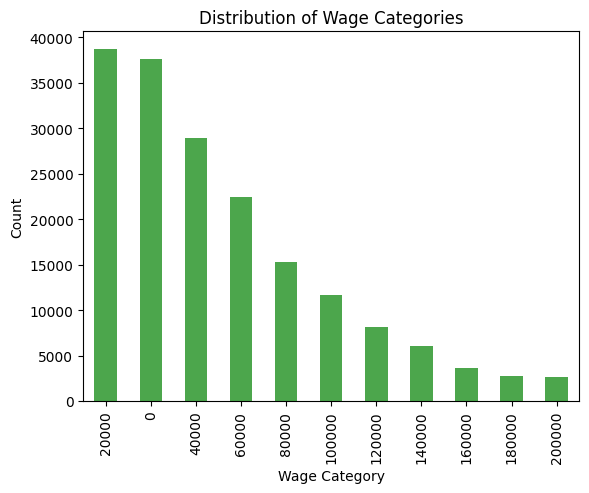

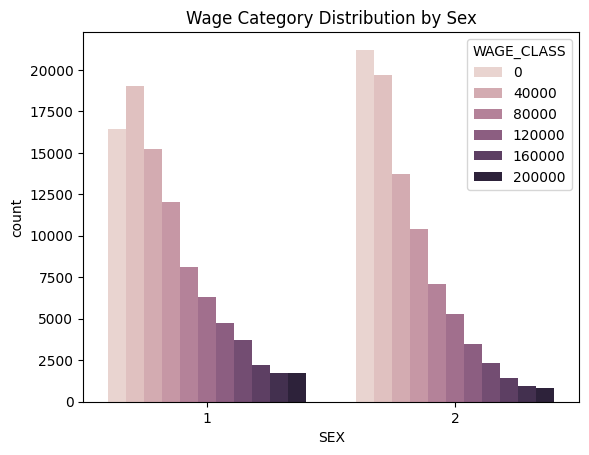

C:\Users\rohan\AppData\Local\Temp\ipykernel_14488\4253700372.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=0)


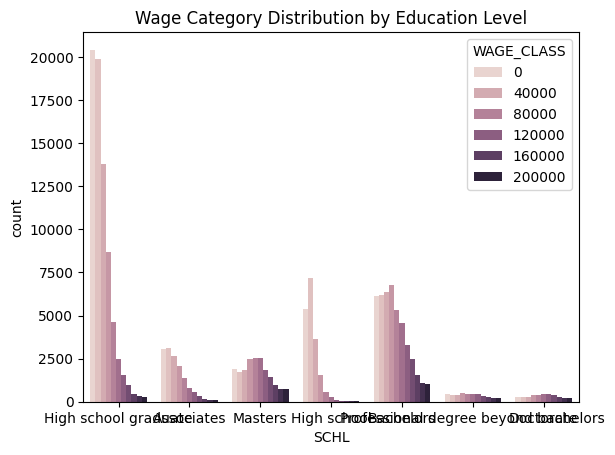

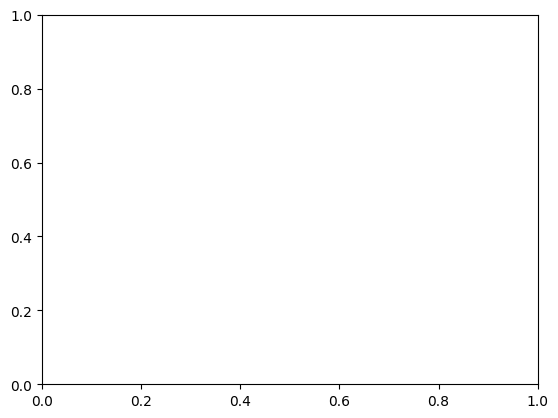

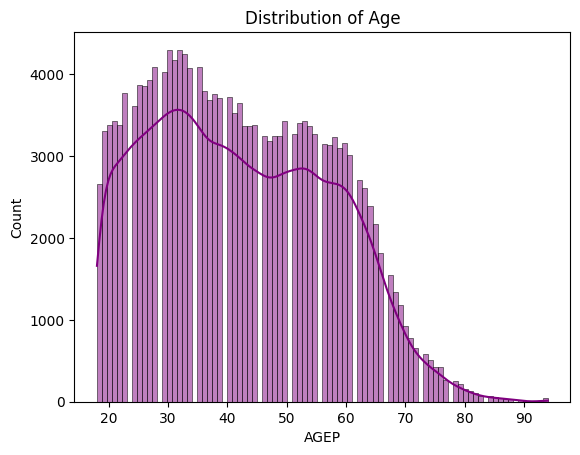

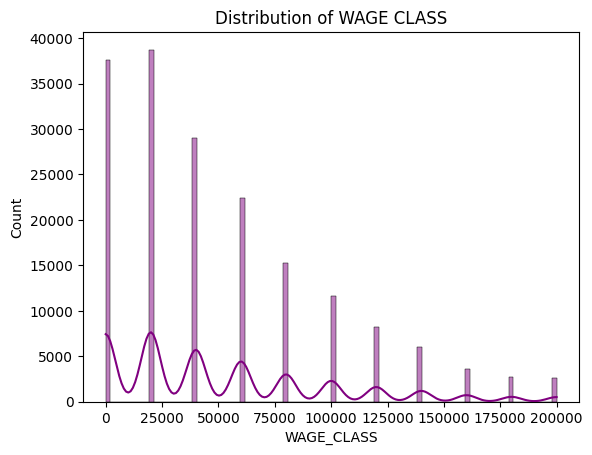

In [16]:
#create a copy for this analysis
data = df_clean.copy()

data['WAGE_CLASS']=(data['WAGP']//20000)*20000

# Plot histogram of the wage variable
plt.hist(data['WAGP'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Wages (WAGP)')
plt.xlabel('Wage')
plt.ylabel('Frequency')
plt.show()




# Summary statistics
print(data['WAGP'].describe())



#================

## Create wage categories for classification
#data['Wage_Category'] = pd.cut(data['WAGP'], [0,   20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000,300000,320000], 
#                                           labels=['0K' ,'20K', '40K', '60K', '80K', '100K', '120K', '140K', '160K', '180K', '200K', '220K', '240K', '260K', '280K','300K' ])

# Inspect the distribution of wage categories
print(data['WAGE_CLASS'].value_counts())
print("RACE counts")
print(data['RACE'].value_counts())
print("=====")


# Plot the distribution of wage categories
data['WAGE_CLASS'].value_counts().plot(kind='bar', color='green', alpha=0.7)
plt.title('Distribution of Wage Categories')
plt.xlabel('Wage Category')
plt.ylabel('Count')
plt.show()

#========================

#Examine Imbalance Across Categorical Features
# Plot wage category distribution by SEX
sns.countplot(data=data, x='SEX', hue='WAGE_CLASS')
plt.title('Wage Category Distribution by Sex')
plt.show()

# Plot wage category distribution by SCHL
sns.countplot(data=data, x='SCHL', hue='WAGE_CLASS')
plt.title('Wage Category Distribution by Education Level')
fig, ax = plt.subplots()
wrap_labels(ax, 20)
plt.show()


#-----

# Plot distribution of continuous features like age 
sns.histplot(data['AGEP'], kde=True, color='purple')
plt.title('Distribution of Age')
plt.show()

# Plot distribution of continuous features like age 
sns.histplot(data['WAGE_CLASS'], kde=True, color='purple')
plt.title('Distribution of WAGE CLASS')
plt.show()

# Create Balanced Dataset

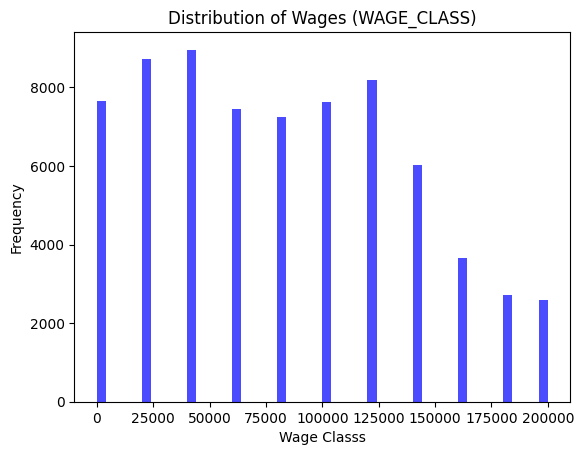

After preprocessing, our data contains 70800 records.


In [17]:


"""
This data shows wage class imbalance.
To correct this imbalance, we will reduce wage classes 0 thru 100000 
to a count similar to the remaining classes

WAGE_CLASS
20000     38720
0         37643
40000     28956
60000     22453
80000     15232
100000    11624
120000     8190
140000     6030
160000     3649
180000     2719
200000     2584
"""
# we will now delete "extra" rows in each class
df = data
df = df.drop(df[df.WAGE_CLASS ==      0].sample(n=30000).index)
df = df.drop(df[df.WAGE_CLASS ==  20000].sample(n=30000).index)
df = df.drop(df[df.WAGE_CLASS ==  40000].sample(n=20000).index)
df = df.drop(df[df.WAGE_CLASS ==  60000].sample(n=15000).index)
df = df.drop(df[df.WAGE_CLASS ==  80000].sample(n= 8000).index)
df = df.drop(df[df.WAGE_CLASS == 100000].sample(n= 4000).index)


# Plot histogram of the wage variable
plt.hist(df['WAGE_CLASS'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Wages (WAGE_CLASS)')
plt.xlabel('Wage Classs')
plt.ylabel('Frequency')
plt.show()



df_balanced=df
# shuffle df_balanced
df_balanced.sample(frac=1) # frac=1 retains all the data
df_balanced.reset_index(drop=True, inplace=True) # reset index

print('After preprocessing, our data contains', df_balanced.shape[0], 'records.')

# XGB Model

In [18]:
%%time
# Copy dataset
#dfStack = df_clean.copy()
dfStack = df_balanced.copy()

# Define target variable
y = dfStack['WAGP_Log'] 
# Drop unnecessary columns
X = dfStack.drop(columns=['WAGP', 'SCIENGRLP', 'SCHL', 'INDP', 'WAGP_Log'])
# Feature Engineering
X['AGEP_WKHP_Interaction'] = X['AGEP'] * X['WKHP']
X['EDU_WKHP_Interaction'] = X['SCHL_Encoded'] * X['WKHP']
X['OCCP_AGE'] = X['AGEP'] * X['OCCP']
# Standardize numerical features
num_features = ['AGEP', 'WKHP', 'INDP_Encoded']
scaler = StandardScaler()
X[num_features] = scaler.fit_transform(X[num_features])
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
#=======================
# Define models
xgb_model = XGBRegressor(
    n_estimators=300, 
    learning_rate=0.05,
    max_depth=12, 
    min_child_weight=2,
    colsample_bytree=0.75,
    subsample=0.9,
    #reg_alpha=0.1,
    #reg_lambda=0.1,
    random_state=5555
)
# Train both models
%time xgb_model.fit(X_train, y_train)
# Get predictions
%time y_pred_xgb = xgb_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGB Model R-squared Score: {r2_xgb:.4f}")

CPU times: total: 48.3 s
Wall time: 18.2 s
CPU times: total: 1.55 s
Wall time: 589 ms
XGB Model R-squared Score: 0.9120
CPU times: total: 49.9 s
Wall time: 18.9 s


# Prediction

In [19]:
    # Get predictions
    y_pred_xgb = xgb_model.predict(X_test)
    
    r2_xgb = r2_score(y_test, y_pred_xgb)
    print(f"r2_xgb: {r2_xgb:.4f}")

r2_xgb: 0.9120


Fitting 3 folds for each of 12 candidates, totalling 36 fits


C:\Users\rohan\AppData\Local\Temp\ipykernel_14488\3558288390.py:23: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pivot = results_df.pivot(index="param_max_depth", columns="param_learning_rate", values="mean_test_score")


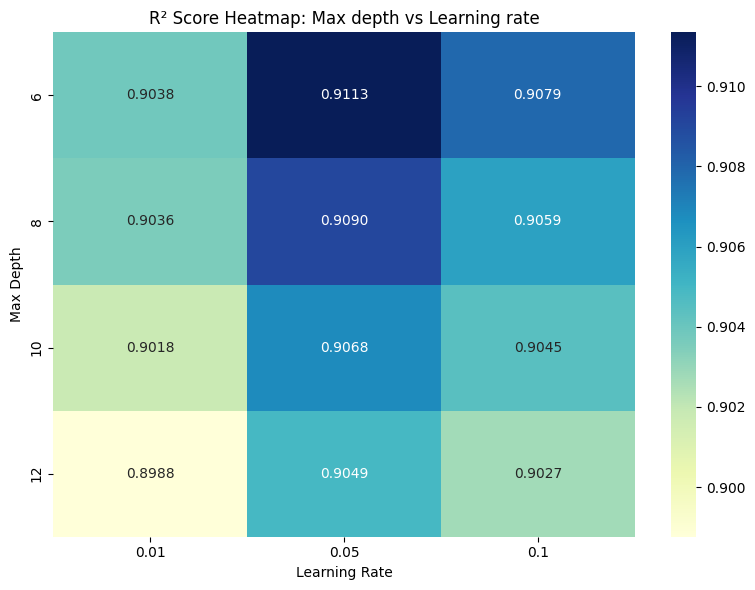

In [24]:


# Parameter grid
param_grid = {
    'max_depth': [6, 8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Grid search
grid_search = GridSearchCV(
    XGBRegressor(n_estimators=300, min_child_weight=2, colsample_bytree=0.75,
                 subsample=0.9, random_state=5555),
    param_grid,
    cv=3,
    scoring='r2',
    return_train_score=True,
    verbose=1
)
grid_search.fit(X_train, y_train)


results_df = pd.DataFrame(grid_search.cv_results_)

# Heatmap
pivot = results_df.pivot(index="param_max_depth", columns="param_learning_rate", values="mean_test_score")
plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("R² Score Heatmap: Max depth vs Learning rate")
plt.xlabel("Learning Rate")
plt.ylabel("Max Depth")
plt.tight_layout()
plt.show()


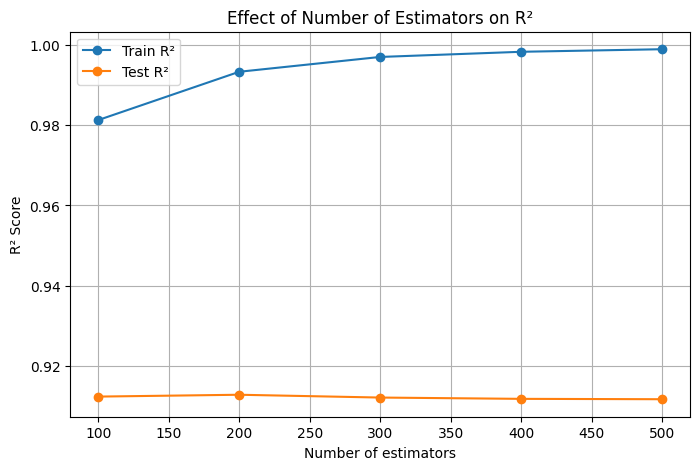

In [27]:
param_values = [100, 200, 300, 400, 500]
train_scores, test_scores = [], []

for val in param_values:
    model = XGBRegressor(n_estimators=val, learning_rate=0.05, max_depth=12,
                         min_child_weight=2, colsample_bytree=0.75, subsample=0.9,
                         random_state=5555)
    model.fit(X_train, y_train)
    train_scores.append(r2_score(y_train, model.predict(X_train)))
    test_scores.append(r2_score(y_test, model.predict(X_test)))

plt.figure(figsize=(8, 5))
plt.plot(param_values, train_scores, label="Train R²", marker='o')
plt.plot(param_values, test_scores, label="Test R²", marker='o')
plt.title("Effect of Number of Estimators on R²")
plt.xlabel("Number of estimators")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True)
plt.show()


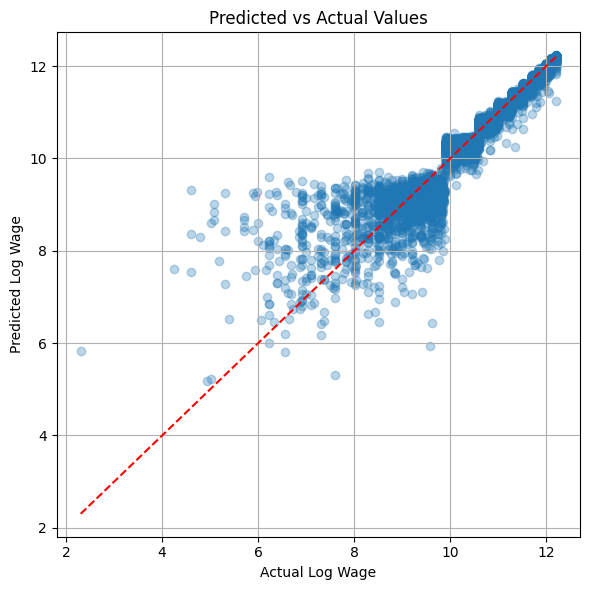

In [26]:


plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual Log Wage")
plt.ylabel("Predicted Log Wage")
plt.title("Predicted vs Actual Values")
plt.grid(True)
plt.tight_layout()
plt.show()


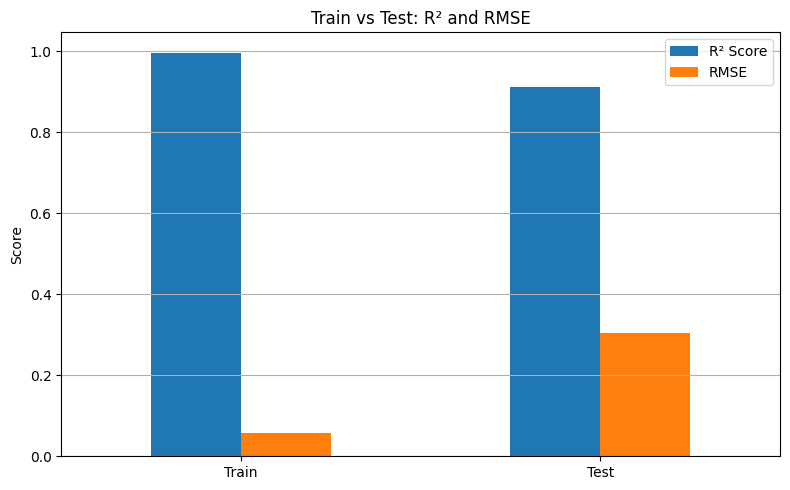

In [28]:


r2_train = r2_score(y_train, xgb_model.predict(X_train))
r2_test = r2_score(y_test, y_pred_xgb)
rmse_train = mean_squared_error(y_train, xgb_model.predict(X_train), squared=False)
rmse_test = mean_squared_error(y_test, y_pred_xgb, squared=False)

metrics_df = pd.DataFrame({
    "R² Score": [r2_train, r2_test],
    "RMSE": [rmse_train, rmse_test]
}, index=["Train", "Test"])

metrics_df.plot(kind="bar", figsize=(8, 5))
plt.title("Train vs Test: R² and RMSE")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


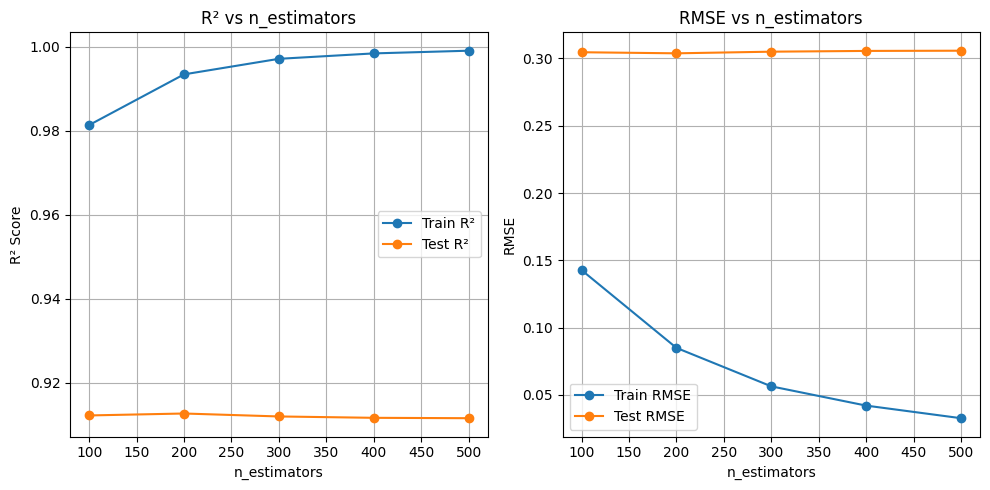

In [29]:
param_values = [100, 200, 300, 400, 500]
r2_train_list, r2_test_list = [], []
rmse_train_list, rmse_test_list = [], []

for val in param_values:
    model = XGBRegressor(n_estimators=val, learning_rate=0.05, max_depth=12,
                         min_child_weight=2, colsample_bytree=0.75, subsample=0.9,
                         random_state=5555)
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    r2_train_list.append(r2_score(y_train, pred_train))
    r2_test_list.append(r2_score(y_test, pred_test))
    rmse_train_list.append(mean_squared_error(y_train, pred_train, squared=False))
    rmse_test_list.append(mean_squared_error(y_test, pred_test, squared=False))

plt.figure(figsize=(10, 5))

# R² plot
plt.subplot(1, 2, 1)
plt.plot(param_values, r2_train_list, marker='o', label='Train R²')
plt.plot(param_values, r2_test_list, marker='o', label='Test R²')
plt.xlabel("n_estimators")
plt.ylabel("R² Score")
plt.title("R² vs n_estimators")
plt.grid(True)
plt.legend()

# RMSE plot
plt.subplot(1, 2, 2)
plt.plot(param_values, rmse_train_list, marker='o', label='Train RMSE')
plt.plot(param_values, rmse_test_list, marker='o', label='Test RMSE')
plt.xlabel("n_estimators")
plt.ylabel("RMSE")
plt.title("RMSE vs n_estimators")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
